In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#1. Implement a VAE 

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
"drive/MyDrive/Reduced",
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False,
    crop_to_aspect_ratio=True,
)

Found 2500 files belonging to 1 classes.


In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
latent_dim = 128

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(scale=1./255)(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(255, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 32)   9248        ['conv2d[0][0]']                 
                                                                                            

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder_outputs = layers.Rescaling(scale=255.)(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 3)        867 

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.MSE(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vae.fit(dataset, epochs=50)

Epoch 1/50
79/79 [==============================] - 614s 6s/step - loss: 16878089.2125 - reconstruction_loss: 15228089.0000 - kl_loss: 75.6905
Epoch 2/50
79/79 [==============================] - 5s 61ms/step - loss: 11500889.9625 - reconstruction_loss: 10382592.0000 - kl_loss: 282.2857
Epoch 3/50
79/79 [==============================] - 5s 62ms/step - loss: 7981622.6188 - reconstruction_loss: 7712052.0000 - kl_loss: 447.9358
Epoch 4/50
79/79 [==============================] - 5s 61ms/step - loss: 7150406.8812 - reconstruction_loss: 6923086.5000 - kl_loss: 468.4795
Epoch 5/50
79/79 [==============================] - 5s 63ms/step - loss: 6478083.8187 - reconstruction_loss: 6335920.0000 - kl_loss: 497.5201
Epoch 6/50
79/79 [==============================] - 5s 61ms/step - loss: 6063372.7875 - reconstruction_loss: 5932331.5000 - kl_loss: 517.2480
Epoch 7/50
79/79 [==============================] - 5s 61ms/step - loss: 5650705.9875 - reconstruction_loss: 5579694.5000 - kl_loss: 540.8058
Epo

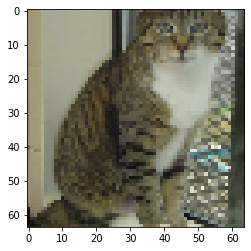

In [9]:
import matplotlib.pyplot as plt
image = list (dataset.take(1))[0][0].numpy()
plt.imshow(image.astype("int32"))

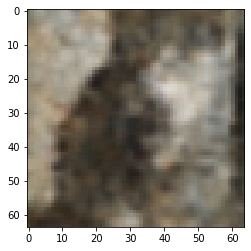

In [10]:
code = vae.encoder.predict(image[None])[0]
res = vae.decoder.predict(code)
res = np.reshape(res, (64, 64, 3))
plt.imshow(res.astype("int32"))

# 2. Implement a cGAN 

In [31]:
!pip install -q git+https://github.com/tensorflow/docs

In [32]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

In [26]:
batch_size = 64
num_channels = 3
num_classes = 2
image_size = 64
latent_dim = 128

In [27]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

130 5


In [57]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((64, 64, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(16 * 16 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((16, 16, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (16, 16), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        2944      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                     

In [58]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [30]:
X_2 = np.empty((2500, 64, 64, 3))
y_2 = np.empty((2500, 2))

import PIL
import os
directory = 'drive/MyDrive/Reduced/cat'
i = 0
for filename in os.listdir(directory):
  an_image = PIL.Image.open("drive/MyDrive/Reduced/cat/" + filename)
  an_image = an_image.resize((64, 64), PIL.Image.ANTIALIAS)
  image_sequence = an_image.getdata()
  image_array = np.array(image_sequence)
  image_array = np.reshape(image_array, (64, 64, 3))
  X_2[i] = image_array 
  y_2[i] = [1, 0] # cat class
  i = i + 1

directory = 'drive/MyDrive/Reduced/dog'
i =1250
for filename in os.listdir(directory):
  an_image = PIL.Image.open("drive/MyDrive/Reduced/dog/" + filename)
  an_image = an_image.resize((64, 64), PIL.Image.ANTIALIAS)
  image_sequence = an_image.getdata()
  image_array = np.array(image_sequence)
  image_array = np.reshape(image_array, (64, 64, 3))
  X_2[i] = image_array 
  y_2[i] = [0, 1] # dog class
  i = i + 1


In [33]:
X_2 = X_2.astype("float32") / 255
y_2 = y_2.astype("float32")

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((X_2, y_2))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [62]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=50)

Epoch 1/50
40/40 [==============================] - 8s 150ms/step - g_loss: 0.9638 - d_loss: 0.5452
Epoch 2/50
40/40 [==============================] - 6s 150ms/step - g_loss: 0.5919 - d_loss: 0.8491
Epoch 3/50
40/40 [==============================] - 6s 150ms/step - g_loss: 0.8726 - d_loss: 0.4625
Epoch 4/50
40/40 [==============================] - 6s 152ms/step - g_loss: 0.6987 - d_loss: 0.8392
Epoch 5/50
40/40 [==============================] - 6s 152ms/step - g_loss: 0.8179 - d_loss: 0.6965
Epoch 6/50
40/40 [==============================] - 6s 151ms/step - g_loss: 0.8320 - d_loss: 0.6452
Epoch 7/50
40/40 [==============================] - 6s 151ms/step - g_loss: 0.7809 - d_loss: 0.6218
Epoch 8/50
40/40 [==============================] - 6s 150ms/step - g_loss: 0.8673 - d_loss: 0.5696
Epoch 9/50
40/40 [==============================] - 6s 150ms/step - g_loss: 0.8012 - d_loss: 0.6243
Epoch 10/50
40/40 [==============================] - 6s 149ms/step - g_loss: 0.8040 - d_loss: 0.6766

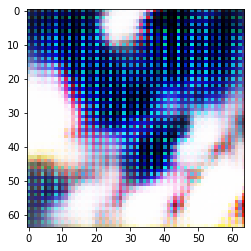

In [65]:
random_latent = tf.random.normal(shape=(1, 128))
label = keras.utils.to_categorical([0], 2)
random_vector_labels = tf.concat([random_latent, label], 1)


fake = cond_gan.generator.predict(random_vector_labels)
import numpy as np
fake = np.resize(fake, (64, 64, 3))
plt.imshow(fake)

# 4. VAE to generate some new dog images

In [10]:
dog = tf.keras.utils.image_dataset_from_directory(
"drive/MyDrive/Reduced/dog",
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False,
    crop_to_aspect_ratio=True,
)

Found 1250 files belonging to 1 classes.


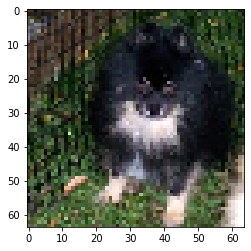

In [13]:
import matplotlib.pyplot as plt
dog_1 = list (dog.take(1))[0][0].numpy()
plt.imshow(dog_1.astype("int32"))

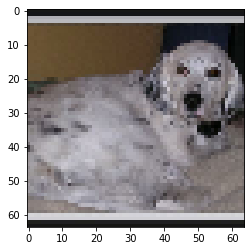

In [14]:
dog_2 = list (dog.take(1))[0][0].numpy()
plt.imshow(dog_2.astype("int32"))

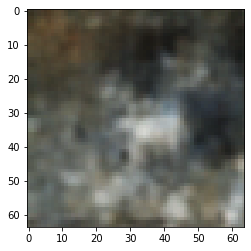

In [17]:
dog_vae = (dog_1 + dog_2)/2
code = vae.encoder.predict(dog_vae[None])[0]
res = vae.decoder.predict(code)
res = np.reshape(res, (64, 64, 3))
plt.imshow(res.astype("int32"))

# 5. cGan to generate some dog images.

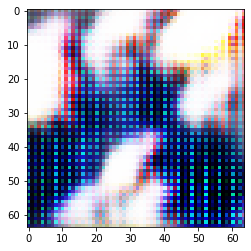

In [67]:
random_latent = tf.random.normal(shape=(1, 128))
label = keras.utils.to_categorical([1], 2)
random_vector_labels = tf.concat([random_latent, label], 1)

dog_cgan = cond_gan.generator.predict(random_vector_labels)
import numpy as np
dog_cgan = np.resize(dog_cgan, (64, 64, 3))
plt.imshow(dog_cgan)

# 6. Repeat step 4 and 5 but for cats.

VAE to generate some new cat images

In [18]:
cat = tf.keras.utils.image_dataset_from_directory(
"drive/MyDrive/Reduced/cat",
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False,
    crop_to_aspect_ratio=True,
)

Found 1250 files belonging to 1 classes.


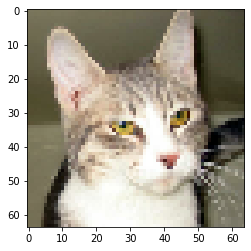

In [20]:
import matplotlib.pyplot as plt
cat_1 = list (cat.take(1))[0][0].numpy()
plt.imshow(cat_1.astype("int32"))

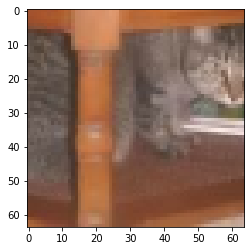

In [21]:
cat_2 = list (cat.take(1))[0][0].numpy()
plt.imshow(cat_2.astype("int32"))

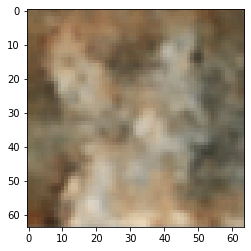

In [22]:
cat_vae = (cat_1 + cat_2)/2
code = vae.encoder.predict(cat_vae[None])[0]
res = vae.decoder.predict(code)
res = np.reshape(res, (64, 64, 3))
plt.imshow(res.astype("int32"))

cGan to generate some cat images

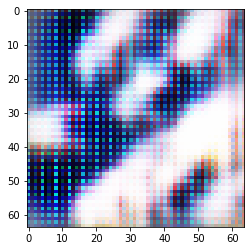

In [69]:
random_latent = tf.random.normal(shape=(1, 128))
label = keras.utils.to_categorical([0], 2)
random_vector_labels = tf.concat([random_latent, label], 1)

dog_cgan = cond_gan.generator.predict(random_vector_labels)
import numpy as np
dog_cgan = np.resize(dog_cgan, (64, 64, 3))
plt.imshow(dog_cgan)

# 7. Generate cat-dogs

VAE to generate cat-dogs

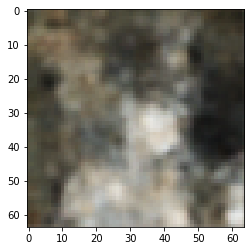

In [23]:
cat_dog_vae = (cat_1 + dog_1)/2
code = vae.encoder.predict(cat_dog_vae[None])[0]
res = vae.decoder.predict(code)
res = np.reshape(res, (64, 64, 3))
plt.imshow(res.astype("int32"))

cGAN to generate cat-dogs

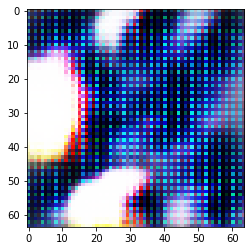

In [73]:
random_latent = tf.random.normal(shape=(1, 128))
label_cat = keras.utils.to_categorical([0], 2)
label_dog = keras.utils.to_categorical([1], 2)
label = (label_cat + label_dog)/2
random_vector_labels = tf.concat([random_latent, label], 1)


cat_dog_cgan = cond_gan.generator.predict(random_vector_labels)
import numpy as np
cat_dog_cgan = np.resize(cat_dog_cgan, (64, 64, 3))
plt.imshow(cat_dog_cgan)